In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import yaml
import torch
import torch_scatter
import alphashape
import numpy as np
from torch import nn
from tqdm import tqdm
from shapely.geometry import Point
from argparse import ArgumentParser, Namespace

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
sys.path.append("/data1/yang_liu/python_workspace/GSPL")
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.models.vanilla_gaussian import VanillaGaussian
from internal.renderers.vanilla_renderer import VanillaRenderer
from internal.utils.graphics_utils import fetch_ply
from internal.utils.general_utils import inverse_sigmoid

In [3]:
torch.set_grad_enabled(False)
torch.set_printoptions(precision=16)

In [4]:
def points_in_polygon(points: torch.Tensor, polygon: torch.Tensor) -> torch.Tensor:
    """
    Determine whether each point in `points` is inside the polygon defined by `polygon`.

    Args:
        points (torch.Tensor): Tensor of shape (N, 2) representing N points (x, y).
        polygon (torch.Tensor): Tensor of shape (M, 2) representing polygon vertices (x, y) in order.
                                 The polygon does not have to be explicitly closed.

    Returns:
        torch.Tensor: A boolean tensor of shape (N,) where True indicates the point is inside the polygon.
    """
    # Ensure the polygon is closed: repeat the first vertex at the end if needed.
    if not torch.allclose(polygon[0], polygon[-1]):
        polygon = torch.cat([polygon, polygon[:1]], dim=0)
    
    # Separate points into x and y coordinates: shape (N, 1)
    x = points[:, 0:1]
    y = points[:, 1:2]

    # Separate polygon coordinates
    poly_x = polygon[:, 0]
    poly_y = polygon[:, 1]
    
    # Form segments of polygon edges; note that the polygon is already closed.
    poly_x1 = poly_x[:-1]  # starting x for each edge
    poly_y1 = poly_y[:-1]  # starting y for each edge
    poly_x2 = poly_x[1:]   # ending x for each edge
    poly_y2 = poly_y[1:]   # ending y for each edge

    # Broadcast to compare each point with each edge. 
    # Condition for y: the y-coordinate of the point is between the y's of the segment's endpoints.
    cond = ((poly_y1.unsqueeze(0) > y) != (poly_y2.unsqueeze(0) > y))

    # Compute the x coordinate where the edge intersects the horizontal line at y.
    # Handle division by zero carefully; since the condition already screens out horizontal lines 
    # (they would not contribute to an intersection) the division is valid.
    x_intersect = poly_x1.unsqueeze(0) + (y - poly_y1.unsqueeze(0)) * (poly_x2.unsqueeze(0) - poly_x1.unsqueeze(0)) / (poly_y2.unsqueeze(0) - poly_y1.unsqueeze(0))
    
    # Check if the x coordinate of the point is to the left of this intersection.
    intersections = (x < x_intersect)

    # Count intersections across all edges for each point.
    count = torch.sum(cond & intersections, dim=1)

    # A point is inside if and only if the count of intersections is odd.
    inside = (count % 2 == 1)
    return inside


def voxel_filtering_no_gt(voxel_size, xy_range, target_xyz, std_ratio=2.0):
    assert len(xy_range) == 4, "Unrecognized xy_range format"
    with torch.no_grad():

        voxel_index = torch.div(torch.tensor(target_xyz[:, :2]).float() - xy_range[None, :2], voxel_size[None, :], rounding_mode='floor')
        voxel_coords = voxel_index * voxel_size[None, :] + xy_range[None, :2] + voxel_size[None, :] / 2

        new_coors, unq_inv, unq_cnt = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
        feat_mean = torch_scatter.scatter(target_xyz[:, 2], unq_inv, dim=0, reduce='mean')
        feat_std = torch_scatter.scatter_std(target_xyz[:, 2], unq_inv, dim=0)

        mask = target_xyz[:, 2] > feat_mean[unq_inv] + std_ratio * feat_std[unq_inv]
        # mask |= target_xyz[:, 2] < feat_mean[unq_inv] - std_ratio * feat_std[unq_inv]

    return mask

In [5]:
data_path = "../data/GauU_Scene/SMBU"
output_path = "../outputs/citygsv2_smbu_sh2_trim"
ply_path = "../data/GauU_Scene/SMBU/SMBU_ds_35.ply"
transform_path = "../data/GauU_Scene/Downsampled/SMBU/transform.txt"
loadable_file = GaussianModelLoader.search_load_file(output_path)
ckpt = torch.load(loadable_file, map_location="cpu")
vox_grid, std_ratio = 10, 3.0

dataparser_config = ckpt["datamodule_hyper_parameters"]["parser"]
if data_path is not None:
    data_path = data_path
else:
    data_path = ckpt["datamodule_hyper_parameters"]["path"]
dataparser_outputs = dataparser_config.instantiate(
    path=data_path,
    output_path=os.getcwd(),
    global_rank=0,
).get_outputs()

cameras = dataparser_outputs.train_set.cameras

appearance group by camera id
loading colmap 3D points
down sample enabled
[colmap dataparser] train set images: 500, val set images: 63, loaded mask: 0
[WARNING depth scale of DJI_20231116105410_0018_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20231119114139_0028_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20231119114930_0060_Zenmuse-L1-mission.JPG out of bound]
[WARNING depth scale of DJI_20231119114931_0061_Zenmuse-L1-mission.JPG out of bound]
found 559 depth maps


# 1. Get Polygon Bound

In [6]:
device = torch.device("cuda")
bkgd_color = torch.tensor(ckpt["hyper_parameters"]["background_color"], device=device)

# load groundtruth point cloud and dataset
model = VanillaGaussian(
    sh_degree=3,
).instantiate()
pcd = fetch_ply(ply_path)
model.setup_from_pcd(xyz=pcd.points, rgb=pcd.colors)
model = model.to("cuda")
model._opacity = nn.Parameter(inverse_sigmoid(torch.ones((model.get_xyz.shape[0], 1), 
                                                            dtype=torch.float, device="cuda") * 0.3))

renderer = VanillaRenderer()
renderer.setup(stage="val")
renderer = renderer.to("cuda")

In [7]:
# count visibility frequency
dataset = dataparser_outputs.train_set
bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda")
with torch.no_grad():
    visible_cnt = torch.zeros(model.get_xyz.shape[0], dtype=torch.long, device="cuda")
    for idx in tqdm(range(0, len(dataset.cameras))):
        camera = dataset.cameras[idx].to_device("cuda")
        output = renderer(camera, model, bg_color=bg_color)
        visible_cnt[output['visibility_filter']] += 1
    xyz = np.float32(model.get_xyz.cpu().numpy())

# load transformation matrix (align z axis to vertical direction)
with open(transform_path, 'r') as f:
    transform = np.float32(np.loadtxt(f))
xyz_homo = np.concatenate([xyz[:, :3], np.ones_like(xyz[:, :1])], axis=-1)
xyz = (xyz_homo @ np.linalg.inv(transform).T)[:, :3]

100%|██████████| 500/500 [00:10<00:00, 45.53it/s]


In [8]:
# generate alpha shape
mask = visible_cnt.cpu().numpy() > 50
hull = alphashape.alphashape(xyz[mask][::200, :2], alpha=2.0)
if (hull.geom_type == 'MultiPolygon'):
    # if MultiPolygon, take the smallest convex Polygon containing all the points in the object
    hull = hull.convex_hull
x, y = hull.exterior.xy

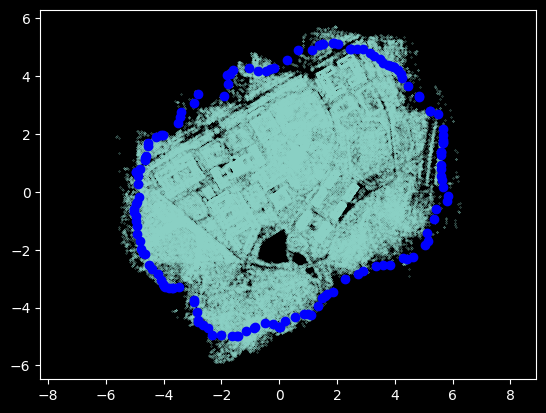

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(xyz[::100, 0], xyz[::100, 1], s=0.05)
# plt.scatter(dataset.cameras.camera_center[:, 0], dataset.cameras.camera_center[:, 1], s=0.1, c='r')
# plt.plot(filtered_pcd[hull_list + [hull_list[0]], 0], filtered_pcd[hull_list + [hull_list[0]], 1], 'r-')
plt.plot(x, y, 'bo')
# plt.grid()
plt.axis('equal')
plt.show()

In [23]:
ckpt = torch.load(loadable_file, map_location="cpu")

In [24]:
model = GaussianModelLoader.initialize_model_from_checkpoint(
    ckpt,
    device=device,
)
model.freeze()
model.pre_activate_all_properties()
xyz_homo = torch.cat([model.get_xyz[:, :3], torch.ones_like(model.get_xyz[:, :1])], dim=-1)
xyz = (xyz_homo @ torch.tensor(np.linalg.inv(transform).T, device=xyz_homo.device))[:, :3]

In [25]:
exterior = torch.tensor(hull.exterior.xy).permute(1, 0).to(xyz.device)
for i in range(exterior.shape[0]):
    print(f"{i}: ({exterior[i][0]}, {exterior[i][1]})")

0: (3.9884414672851562, 4.336952209472656)
1: (4.126871585845947, 4.207327842712402)
2: (4.217615604400635, 4.064425468444824)
3: (4.256063461303711, 3.9492080211639404)
4: (4.438923358917236, 3.6802194118499756)
5: (4.820512294769287, 3.3152596950531006)
6: (4.824588298797607, 3.299811840057373)
7: (5.2113871574401855, 2.78580379486084)
8: (5.216536998748779, 2.784987688064575)
9: (5.481924057006836, 2.6861207485198975)
10: (5.680516719818115, 2.1857500076293945)
11: (5.670675277709961, 1.9817728996276855)
12: (5.6698737144470215, 1.798307180404663)
13: (5.654092311859131, 1.730568528175354)
14: (5.649902820587158, 1.6962543725967407)
15: (5.604102611541748, 1.3981462717056274)
16: (5.606102466583252, 1.3799660205841064)
17: (5.606070041656494, 1.2842110395431519)
18: (5.602895736694336, 0.9186587333679199)
19: (5.591551780700684, 0.8052390813827515)
20: (5.597771167755127, 0.5393661856651306)
21: (5.616523742675781, 0.42871910333633423)
22: (5.674082279205322, 0.17765246331691742)
23

In [26]:
# check if each point in xyz is within the hull
exterior = torch.tensor(hull.exterior.xy).permute(1, 0).to(xyz.device)
# adjust exteriors according to lfls
# adjusted_point = exterior[37:38]
# adjusted_point[0, 0], adjusted_point[0, 1] = 1.0, -2.0
# exterior = torch.cat([exterior[:20], exterior[30:34], adjusted_point, exterior[60:90], exterior[104:]], dim=0)

xyz = torch.tensor(xyz)
inside = points_in_polygon(xyz[:, :2], exterior)
print(f"{inside.sum()} of {len(inside)} gaussians are inside the region")

3575639 of 5426984 gaussians are inside the region


/tmp/ipykernel_32053/1283737405.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyz = torch.tensor(xyz)


(-7.804150652885437, 10.749108862876891, -10.25546317100525, 9.397800016403199)

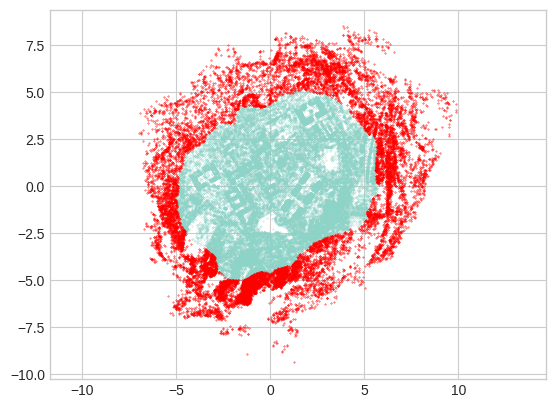

In [27]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
# plt.scatter(xyz[::100, 0].cpu().numpy(), xyz[::100, 1].cpu().numpy(), s=0.05)
plt.scatter(xyz[inside][::100, 0].cpu().numpy(), xyz[inside][::100, 1].cpu().numpy(), s=0.05)
plt.scatter(xyz[~inside][::100, 0].cpu().numpy(), xyz[~inside][::100, 1].cpu().numpy(), c='r', s=0.1)
plt.axis('equal')

In [28]:
mask = (~inside) | (torch.max(model.get_scaling, dim=1).values > dataparser_outputs.camera_extent * ckpt['hyper_parameters']['density'].percent_dense * 5)

with torch.no_grad():
    x_min, x_max = xyz[:, 0].min(), xyz[:, 0].max()
    y_min, y_max = xyz[:, 1].min(), xyz[:, 1].max()
    voxel_size = torch.tensor([(x_max - x_min) / vox_grid, (y_max - y_min) / vox_grid], device="cuda")
    xy_range = torch.tensor([x_min, y_min, x_max, y_max], device="cuda")
    mask |= voxel_filtering_no_gt(voxel_size, xy_range, xyz, std_ratio).bool()
    print(f"Filtered out {mask.sum()} of {len(mask)} gaussians according to visibility and statistics")

Filtered out 1858932 of 5426984 gaussians according to visibility and statistics


/tmp/ipykernel_32053/2755290216.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel_index = torch.div(torch.tensor(target_xyz[:, :2]).float() - xy_range[None, :2], voxel_size[None, :], rounding_mode='floor')


In [29]:
# ckpt['state_dict']['gaussian_model.gaussians.opacities'][mask] = -13.8  # 1e-6
# extract gaussian properties
property_names = []
param_list_key_by_name = {}
gaussian_property_dict_key_prefix = "gaussian_model.gaussians."
density_controller_state_dict_key_prefix = "density_controller."
for key, value in ckpt["state_dict"].items():
    if key.startswith(gaussian_property_dict_key_prefix):
        param_list_key_by_name.setdefault(key, []).append(value[~mask.cpu()])
        property_names.append(key[len(gaussian_property_dict_key_prefix):])
    elif key.startswith(density_controller_state_dict_key_prefix):
        param_list_key_by_name.setdefault(key, []).append(value)
for i in param_list_key_by_name:
    ckpt["state_dict"][i] = torch.concat(param_list_key_by_name[i], dim=0)
torch.save(ckpt, loadable_file.replace('.ckpt', '_filtered.ckpt'))